In [1]:
from functions import *

In [3]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import os
import rasterio
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import pandas as pd
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pyproj
from geopandas.tools import sjoin
from shapely.geometry import Point
import requests
from scipy.stats import ks_2samp
import shutil
from matplotlib.colors import LogNorm

# Load data

#### Load raw data paths

In [31]:
W = 128
source_path = '../data/raw/'
data_paths = ['lst','ndvi']#, 'ndvi', 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {}
for i,dir_p in enumerate(dir_paths):
    all_dir_paths[data_paths[i]] = []
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p:
            if not files and not dirs:
                os.rmdir(subdir)
            else:
                all_dir_paths[data_paths[i]].append(subdir)
        #data, times = load_data(dir_paths,W,list_rgb)
all_dir_paths


{'lst': ['../data/raw/lst/cell_67',
  '../data/raw/lst/cell_2',
  '../data/raw/lst/cell_70',
  '../data/raw/lst/cell_31',
  '../data/raw/lst/cell_19',
  '../data/raw/lst/cell_29',
  '../data/raw/lst/cell_71',
  '../data/raw/lst/cell_49',
  '../data/raw/lst/cell_43',
  '../data/raw/lst/cell_10',
  '../data/raw/lst/cell_13',
  '../data/raw/lst/cell_41',
  '../data/raw/lst/cell_21',
  '../data/raw/lst/cell_11',
  '../data/raw/lst/cell_58',
  '../data/raw/lst/cell_56',
  '../data/raw/lst/cell_74',
  '../data/raw/lst/cell_37',
  '../data/raw/lst/cell_62',
  '../data/raw/lst/cell_72',
  '../data/raw/lst/cell_65',
  '../data/raw/lst/cell_8',
  '../data/raw/lst/cell_80',
  '../data/raw/lst/cell_68',
  '../data/raw/lst/cell_9',
  '../data/raw/lst/cell_18',
  '../data/raw/lst/cell_69',
  '../data/raw/lst/cell_3',
  '../data/raw/lst/cell_46',
  '../data/raw/lst/cell_23',
  '../data/raw/lst/cell_28',
  '../data/raw/lst/cell_33',
  '../data/raw/lst/cell_54',
  '../data/raw/lst/cell_76',
  '../data/

In [5]:
dir_path = '../data/raw/wt'
water_temp = pd.read_csv(f'{dir_path}/water_temp.csv', index_col=0)
water_temp

1      2     3      4      5      6      7      8  \
Zeitstempel                                                                  
2013-03-01 00:00:00   5.76   1.05  2.72   2.91   3.61   5.86   3.23   7.46   
2013-04-01 00:00:00   8.16   3.23  3.62   5.43   5.91   8.54   5.20   8.94   
2013-05-01 00:00:00  12.06   5.38  4.49   6.83   8.68  12.21   8.49   9.46   
2013-06-01 00:00:00  15.15   9.05  5.01   8.56  12.00  15.21  12.85  10.42   
2013-07-01 00:00:00  19.52  12.63  6.34  10.80  15.42  21.28  17.35  11.98   
...                    ...    ...   ...    ...    ...    ...    ...    ...   
2024-05-01 00:00:00  13.94   6.03  4.81   7.26  10.67  13.85  11.10  10.58   
2024-06-01 00:00:00  16.58   9.45  5.38   8.63  13.05  17.00  13.57  11.62   
2024-07-01 00:00:00  19.75  12.10  6.82  10.47  15.52  20.68  16.94  12.39   
2024-08-01 00:00:00  21.82  14.09  7.55  12.48  16.50  23.24  18.44  13.35   
2024-09-01 00:00:00  18.45  10.32  5.91   9.56  12.78  19.08  13.64  11.79   

                         9     10  ...     72     73     74     75     76  \
Zeitstempel                        ...                                      
2013-03-01 00:00:00   6.24   5.59  ...   5.96   8.20   4.04   6.69   6.04   
2013-04-01 00:00:00   8.94   8.33  ...   8.02   9.92   5.92   9.93   8.77   
2013-05-01 00:00:00  10.16  11.65  ...   8.53  10.93   6.86  13.71  10.15   
2013-06-01 00:00:00  13.67  15.12  ...  10.90  12.93   8.49  17.17  14.04   
2013-07-01 00:00:00  19.61  20.50  ...  13.75  16.97  10.80  20.67  20.99   
...                    ...    ...  ...    ...    ...    ...    ...    ...   
2024-05-01 00:00:00  12.20  13.40  ...  10.36  12.10   7.63  15.62  12.29   
2024-06-01 00:00:00  15.24  16.79  ...  12.24  13.55   9.03  18.39  15.95   
2024-07-01 00:00:00  18.90  20.38  ...  14.30  15.95  10.74  20.82  19.92   
2024-08-01 00:00:00  22.41  22.75  ...  16.34  17.93  11.85  21.27  23.87   
2024-09-01 00:00:00  16.21  18.08  ...  12.46  14.41   9.55  17.76  16.90   

                        77     78     79     80      81  
Zeitstempel                                              
2013-03-01 00:00:00   6.06   5.48   3.83   4.64    0.96  
2013-04-01 00:00:00   8.77   8.22   8.19   8.90    1.56  
2013-05-01 00:00:00  12.35  10.14  10.75  11.26    1.31  
2013-06-01 00:00:00  15.36  13.41  13.63  15.18    1.31  
2013-07-01 00:00:00  21.30  17.45  17.22  20.13    1.25  
...                    ...    ...    ...    ...     ...  
2024-05-01 00:00:00  13.95  11.97  12.41  14.02    1.79  
2024-06-01 00:00:00  17.04  14.46  14.65  16.51    1.56  
2024-07-01 00:00:00  20.67  17.49  17.22  19.97   Lücke  
2024-08-01 00:00:00  23.25  18.12  18.68  21.36  223.36  
2024-09-01 00:00:00  19.28  14.64  15.01  15.49    0.19  

[139 rows x 81 columns]

In [6]:
water_temp.index = pd.to_datetime(water_temp.index).strftime('%Y-%m')

In [7]:
'''pattern = r'^cell_\d+_'
for path in all_dir_paths['ndvi']:
    image_files = os.listdir(path)
    new_files = [re.sub(pattern, '', filename) for filename in image_files]
    new_files = [new_name.replace('_','-',1) for new_name in new_files]
    for i,img in enumerate(image_files):
        old_path = os.path.join(path, img)
        new_path = os.path.join(path, new_files[i])
        print('From ', old_path,'to ', new_path)
        os.rename(old_path, new_path)'''



<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_125381/2340356355.py:1: SyntaxWarning: invalid escape sequence '\d'
  '''pattern = r'^cell_\d+_'


"pattern = r'^cell_\\d+_'\nfor path in all_dir_paths['ndvi']:\n    image_files = os.listdir(path)\n    new_files = [re.sub(pattern, '', filename) for filename in image_files]\n    new_files = [new_name.replace('_','-',1) for new_name in new_files]\n    for i,img in enumerate(image_files):\n        old_path = os.path.join(path, img)\n        new_path = os.path.join(path, new_files[i])\n        print('From ', old_path,'to ', new_path)\n        os.rename(old_path, new_path)"

#### Load images and times

In [65]:
t=[]
total_data = {}
total_times = {}

In [66]:
# Load input data
time_split=False
for k,v in all_dir_paths.items():
    
    if k != 'discharge' and k != 'slope' and k != 'altitude':
        print('Doing',k)
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)
            
        data, times = load_data(v,W,list_rgb)
    
        labels = []
        for ki,value in data.items():
            labels+=[ki.split('/')[-1]]*len(value)
        
        data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
        times_list = [t for sublist in times for t in sublist]
        
        if time_split:
            dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
            pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
            sorted_dates, data_values, labels = zip(*pairs)
            times_list = [date.strftime('%Y-%m') for date in sorted_dates]
            
        total_data[k] = np.array(data_values)
        total_times[k] = times_list
        print(k,':' ,total_data[k].shape)

Doing lst
lst : (11259, 128, 128, 3)
Doing ndvi


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)


ndvi : (11259, 128, 128)


<Axes: >

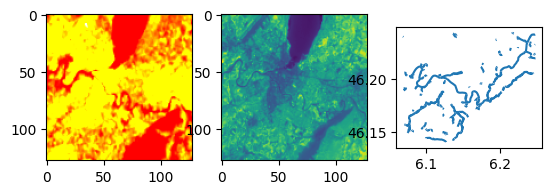

In [67]:
### Small check
fig,ax = plt.subplots(1,3)
ax[0].imshow(np.clip(total_data['lst'][11]*(6/255),0,1))
ax[1].imshow(total_data['ndvi'][11])
river_cells[labels[11]].plot(ax=ax[2])

In [10]:
total_cells = []
for v in all_dir_paths['lst']:
    cell = v.split('/')[-1]
    total_cells.extend([cell]*len(times[0]))

In [68]:
lst = total_data['lst']
ndvi = total_data['ndvi']
#data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
#print('targets shape:', data_targets.shape)

inputs shape: (11259, 128, 128, 3) (11259, 128, 128)


In [69]:
time_slots = [el for t in times for el in t]
time_slots = np.array(time_slots)
time_slots

array(['2013-03', '2013-04', '2013-05', ..., '2024-07', '2024-08',
       '2024-09'], dtype='<U7')

In [13]:
len(time_slots)

11259

#### Load rivers

In [18]:
import os
import fiona
import geopandas as gpd
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union

river_cells = {}
output_directory = '../data/external/shp/river_cells_oficial'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])

    except Exception as e:
        print(f"Error processing file: {riv}",e)
        pass
        

Processing file: station_cell_37.shp
Added cell_37
Processing file: station_cell_8.shp
Added cell_8
Processing file: station_cell_33.shp
Added cell_33
Processing file: station_cell_9.shp
Added cell_9
Processing file: station_cell_42.shp
Added cell_42
Processing file: station_cell_78.shp
Added cell_78
Processing file: station_cell_6.shp
Added cell_6
Processing file: station_cell_46.shp
Added cell_46
Processing file: station_cell_31.shp
Added cell_31
Processing file: station_cell_59.shp
Added cell_59
Processing file: station_cell_63.shp
Added cell_63
Processing file: station_cell_11.shp
Added cell_11
Processing file: station_cell_36.shp
Added cell_36
Processing file: station_cell_65.shp
Added cell_65
Processing file: station_cell_56.shp
Added cell_56
Processing file: station_cell_12.shp
Added cell_12
Processing file: station_cell_72.shp
Added cell_72
Processing file: station_cell_24.shp
Added cell_24
Processing file: station_cell_38.shp
Added cell_38
Processing file: station_cell_80.shp


In [86]:
river_cells['cell_31'].shape

(3213, 24)

# Delete unuseful data

In [70]:
del_indices = set()
fixed_ndvi = []
test_index = 0
for index in range(0,lst.shape[0]):
  # Obtain percentage of black and white pixels of lst
  print('imatge', index)
  for k in total_data.keys():
    if k != 'wt':
        print('fent', k)
        if len(total_data[k][index].shape) == 2:
          img_gray = total_data[k][index]
        else:
          img_gray = np.dot(total_data[k][index][...,:3], [0.2989, 0.5870, 0.1140])
        
        blacks = img_gray==0
        percentage_b = np.sum(blacks)/blacks.size * 100
        whites = img_gray>=240
        percentage_w = np.sum(whites)/whites.size * 100
        num_nans = np.sum(np.isnan(img_gray))
        percentage_nans = (num_nans*100)/(img_gray.size)
        print('tinc ',num_nans,' sobre ',img_gray.size,' ocupen un percentatge', percentage_nans)
        conditions = [np.all(img_gray == img_gray[0, 0]), percentage_b > 50, percentage_w > 50,np.all(np.isnan(img_gray)), percentage_nans > 50]
        
        if True in conditions:
            del_indices.add(index)
            break
        elif k == 'ndvi':
            new_ndvi = np.where(np.isnan(total_data[k][index]), 0.0, total_data[k][index])
            fixed_ndvi.append(new_ndvi)
  print()
  

imatge 0
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 1
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0
fent ndvi
tinc  14245  sobre  16384  ocupen un percentatge 86.944580078125

imatge 2
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 3
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0
fent ndvi
tinc  16384  sobre  16384  ocupen un percentatge 100.0

imatge 4
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 5
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0
fent ndvi
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 6
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 7
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 8
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 9
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0

imatge 10
fent lst
tinc  0  sobre  16384  ocupen un percentatge 0.0
fent ndvi
tinc  11774  sobre  16384  ocupen un percen

In [71]:
fixed_ndvi = np.array(fixed_ndvi)

In [72]:
slots = np.delete(time_slots,list(del_indices))

In [73]:
len(slots)

1654

In [74]:
clean_cells = np.delete(np.array(total_cells),list(del_indices))
len(clean_cells)

1654

In [75]:
len(fixed_ndvi)

1654

### Clean water temperature data

In [76]:
wt_values = pd.DataFrame(columns=["Cell", "Date", "WaterTemp"])
del_cells={}
for count in range(len(clean_cells)):
    keep_cell = clean_cells[count]
    keep_date = slots[count]
    temp_value = water_temp.loc[keep_date][keep_cell.split('_')[-1]]

    # Comprobar si temp_value no es 'Lücke' y es un número válido
    if temp_value != 'Lücke' and isinstance(temp_value, (int, float)) and not np.isnan(temp_value):
        new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "WaterTemp": [temp_value]})
        wt_values = pd.concat([wt_values, new_row], ignore_index=True)
    elif isinstance(temp_value, str) and temp_value.replace('.', '', 1).isdigit():
        # Convertir temp_value a float si es una cadena numérica
        new_row = pd.DataFrame({"Cell": [keep_cell], "Date": [keep_date], "WaterTemp": [float(temp_value)]})
        wt_values = pd.concat([wt_values, new_row], ignore_index=True)
    else:
        # Si el valor no es numérico o es 'Lücke', añadirlo a del_cells
        if keep_cell not in del_cells:
            del_cells[keep_cell] = [keep_date]
        else:
            del_cells[keep_cell].append(keep_date)
        print('hola', temp_value, keep_cell, keep_date)

del_cells

/tmp/ipykernel_3833829/1651386172.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wt_values = pd.concat([wt_values, new_row], ignore_index=True)


hola nan cell_70 2013-12
hola nan cell_70 2014-03
hola nan cell_70 2014-04
hola nan cell_70 2014-08
hola nan cell_70 2015-08
hola nan cell_70 2017-06
hola nan cell_70 2017-10
hola nan cell_70 2017-11
hola nan cell_70 2017-12
hola nan cell_70 2018-04
hola nan cell_70 2018-06
hola nan cell_70 2018-08
hola nan cell_70 2019-01
hola nan cell_70 2019-09
hola nan cell_70 2020-05
hola nan cell_70 2021-01
hola nan cell_70 2021-06
hola nan cell_70 2021-09
hola nan cell_70 2021-10
hola nan cell_70 2022-02
hola nan cell_70 2022-08
hola nan cell_70 2022-09
hola nan cell_70 2023-02
hola nan cell_70 2023-03
hola nan cell_70 2024-02
hola Lücke cell_81 2024-07


{'cell_70': ['2013-12',
  '2014-03',
  '2014-04',
  '2014-08',
  '2015-08',
  '2017-06',
  '2017-10',
  '2017-11',
  '2017-12',
  '2018-04',
  '2018-06',
  '2018-08',
  '2019-01',
  '2019-09',
  '2020-05',
  '2021-01',
  '2021-06',
  '2021-09',
  '2021-10',
  '2022-02',
  '2022-08',
  '2022-09',
  '2023-02',
  '2023-03',
  '2024-02'],
 'cell_81': ['2024-07']}

# Download preprocessed data

#### Clean preprocessed directories

In [77]:
raw_data_path = '../data/raw/'
preprocessed_data_path = '../data/preprocessed/'

data = ['lst', 'ndvi', 'wt']#,'wt_interpolated', 'lst/masked']
for d in data:
    dest_dir = os.path.join(preprocessed_data_path, d)
    os.makedirs(dest_dir, exist_ok=True)
    clear_directory(dest_dir)


In [91]:
os.makedirs('../data/preprocessed/wt',exist_ok=True)
wt_values.to_csv('../data/preprocessed/wt/water_temp.csv')

#### Copy preprocessed images

In [79]:
import rasterio
from rasterio.transform import from_origin, from_bounds
import numpy as np

def save_raster(raster_array, filepath, shp, resolution=30, nodata_value=0.0):
    
    resolution = 30
    x_min, y_min, x_max, y_max = shp.total_bounds
    width, height = raster_array.shape[1], raster_array.shape[0]
    resolution_x = (x_max - x_min) / width
    resolution_y = (y_max - y_min) / height

    print(width,height,raster_array.shape[0],raster_array.shape[1])
    
    #transform = from_origin(x_min, y_max, resolution, resolution)
    transform = from_bounds(x_min, y_min, x_max, y_max, width, height)

    with rasterio.open(
        filepath,
        'w',
        driver='GTiff',
        height=raster_array.shape[0],
        width=raster_array.shape[1],
        count=len(raster_array.shape),
        dtype=raster_array.dtype,
        crs=shp.crs.to_string(),  # Ensure correct CRS
        transform=transform,
        nodata=0.0
    ) as dst:
        if len(raster_array.shape) == 3:
            dst.write(raster_array[:, :, 0], 1)  # Red channel
            dst.write(raster_array[:, :, 1], 2)  # Green channel
            dst.write(raster_array[:, :, 2], 3)  # Blue channel
        else:
            dst.write(raster_array, 1)
    print(f"Raster saved to {filepath} with bounds {x_min}, {y_min}, {x_max}, {y_max}, {shp.crs.to_string()}")




In [80]:
from collections import Counter

for d, paths in all_dir_paths.items():
    count = 0
    included = 0
    imgs_per_river = Counter()
    imgs_out=0
    
    for cell_path in paths:
        try:
            source_dir = cell_path
            cell = cell_path.split('/')[-1]
            
            river = river_cells[cell]
            files = os.listdir(source_dir)
            sorted_files = sorted(files, key=extract_year_month_from_filename)

            dest_dir = os.path.join(preprocessed_data_path, f'{d}/{cell}')
            os.makedirs(dest_dir, exist_ok=True)
    
            for file in sorted_files:
                if count not in del_indices:
                    print('Cell',cell)
                    date = file.split('_')[-1].split('.')[0]
                    
                    if cell in del_cells and date in del_cells[cell]:
                            print('Not this one', cell,date)
                            count+=1
                            included+=1
                            continue
                    
                    if d == 'ndvi':
                        name = f'{dest_dir}/ndvi_{date}.tiff'
                        save_raster(fixed_ndvi[included], name, river)
                        print()
                        print(f'Copied: ndvi_{date}, at {dest_dir}')
                        print()
                    
                    else:
                        dst_path = os.path.join(dest_dir, file)
                        src_path = os.path.join(source_dir, file)
                        # Copy the file to the destination folder
                        shutil.copy(src_path, dst_path)
                        print()
                        print(f'Copied: {file}, from {src_path}, to {dst_path}')
                    included+=1
                    imgs_per_river[cell] += 1
                count+=1
                
        except Exception as e:
            print(e)
            imgs_out += len(os.listdir(source_dir))
            rr = river_cells[cell]
            print(cell)
            print()
            print('afegeixo',len(os.listdir(source_dir)), 'imatges no processades')
            count += len(os.listdir(source_dir))
            pass
        
                

Cell cell_67

Copied: image_2013-08.tiff, from ../data/raw/lst/cell_67/image_2013-08.tiff, to ../data/preprocessed/lst/cell_67/image_2013-08.tiff
Cell cell_67

Copied: image_2014-02.tiff, from ../data/raw/lst/cell_67/image_2014-02.tiff, to ../data/preprocessed/lst/cell_67/image_2014-02.tiff
Cell cell_67

Copied: image_2015-05.tiff, from ../data/raw/lst/cell_67/image_2015-05.tiff, to ../data/preprocessed/lst/cell_67/image_2015-05.tiff
Cell cell_67

Copied: image_2018-06.tiff, from ../data/raw/lst/cell_67/image_2018-06.tiff, to ../data/preprocessed/lst/cell_67/image_2018-06.tiff
Cell cell_67

Copied: image_2020-03.tiff, from ../data/raw/lst/cell_67/image_2020-03.tiff, to ../data/preprocessed/lst/cell_67/image_2020-03.tiff
Cell cell_67

Copied: image_2020-06.tiff, from ../data/raw/lst/cell_67/image_2020-06.tiff, to ../data/preprocessed/lst/cell_67/image_2020-06.tiff
Cell cell_67

Copied: image_2021-09.tiff, from ../data/raw/lst/cell_67/image_2021-09.tiff, to ../data/preprocessed/lst/cell_

In [81]:
print(np.sum(list(imgs_per_river.values())))
print(imgs_per_river)
print(imgs_out)
print(len(slots))
print(len(imgs_per_river))
print(included)

1628
Counter({'cell_33': 46, 'cell_80': 44, 'cell_38': 41, 'cell_63': 41, 'cell_71': 39, 'cell_28': 35, 'cell_16': 35, 'cell_31': 32, 'cell_39': 32, 'cell_34': 30, 'cell_13': 28, 'cell_77': 28, 'cell_46': 27, 'cell_73': 27, 'cell_37': 26, 'cell_23': 26, 'cell_17': 26, 'cell_78': 26, 'cell_27': 26, 'cell_74': 25, 'cell_51': 25, 'cell_29': 24, 'cell_22': 24, 'cell_12': 24, 'cell_11': 23, 'cell_9': 23, 'cell_81': 23, 'cell_30': 23, 'cell_56': 22, 'cell_65': 22, 'cell_68': 21, 'cell_76': 21, 'cell_57': 21, 'cell_21': 20, 'cell_7': 20, 'cell_42': 20, 'cell_53': 20, 'cell_40': 20, 'cell_66': 20, 'cell_47': 20, 'cell_19': 19, 'cell_58': 19, 'cell_72': 19, 'cell_18': 19, 'cell_20': 19, 'cell_59': 19, 'cell_75': 19, 'cell_61': 19, 'cell_55': 19, 'cell_52': 18, 'cell_4': 18, 'cell_43': 17, 'cell_54': 17, 'cell_48': 17, 'cell_14': 17, 'cell_41': 16, 'cell_62': 16, 'cell_45': 16, 'cell_2': 15, 'cell_10': 15, 'cell_79': 15, 'cell_26': 15, 'cell_67': 13, 'cell_35': 13, 'cell_44': 13, 'cell_25': 13, 

CHECK

In [88]:
dir_paths = ['../data/preprocessed/lst/cell_73']
W = 128
list_rgb = [True]
data, time_slots_n = load_data(dir_paths,W,list_rgb)

(27, 128, 128, 3)
0


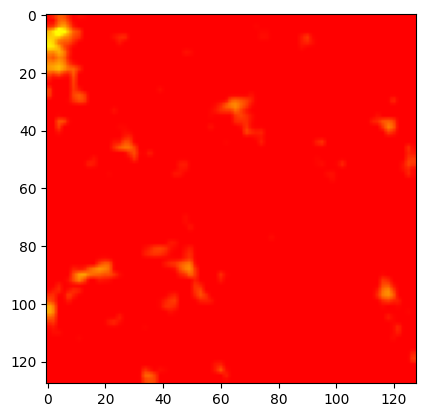

0


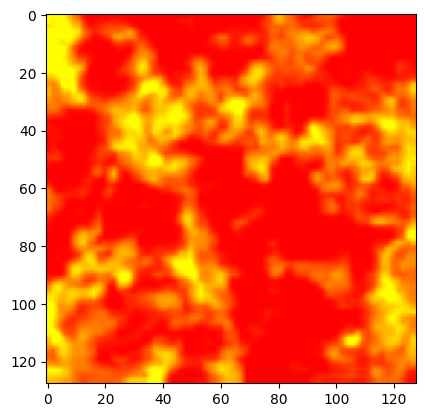

0


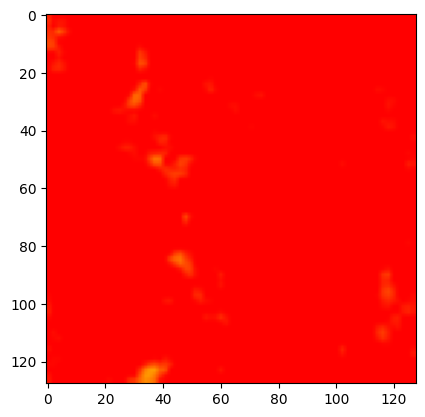

0


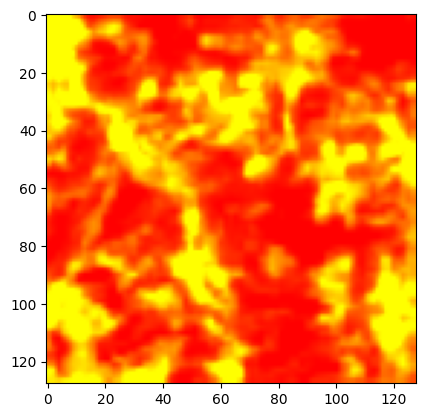

0


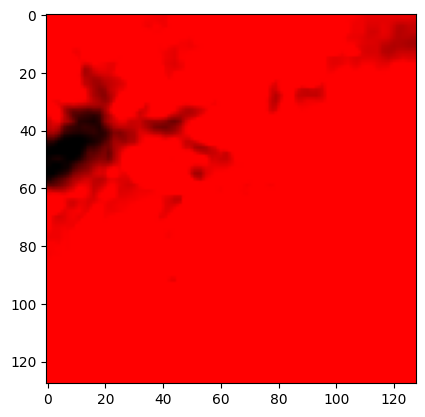

0


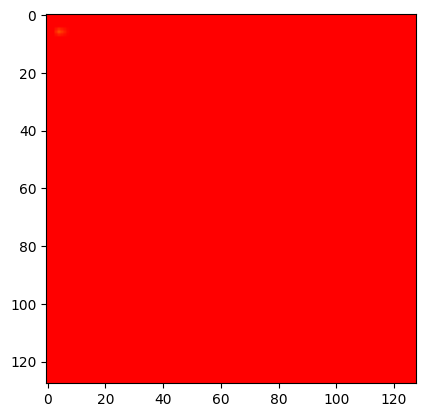

0


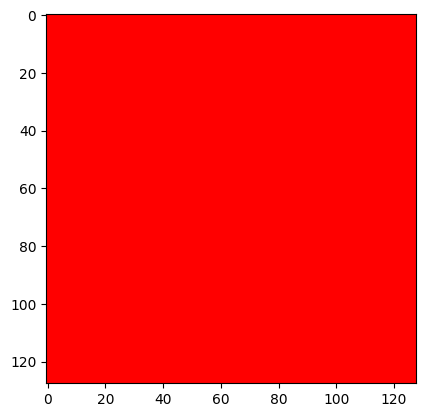

0


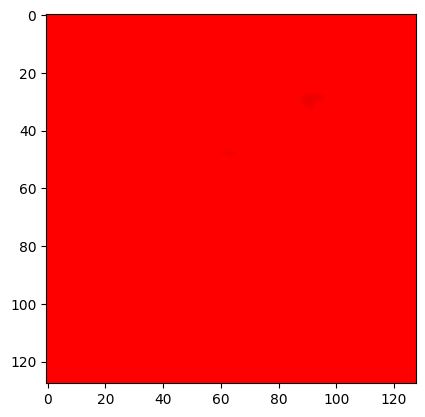

0


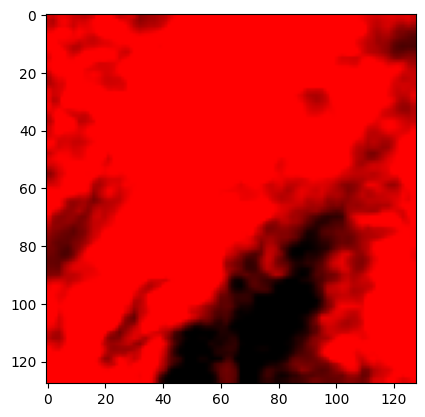

0


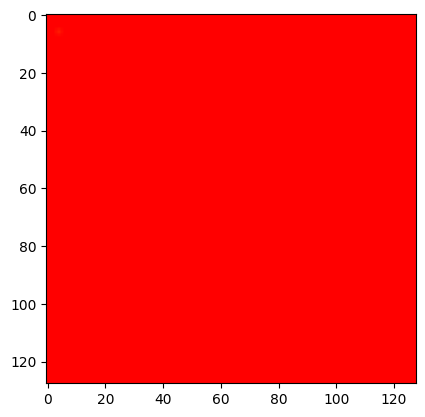

0


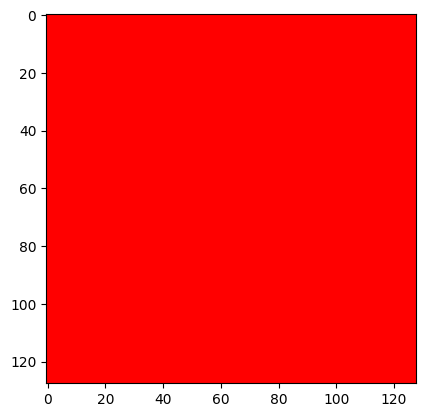

0


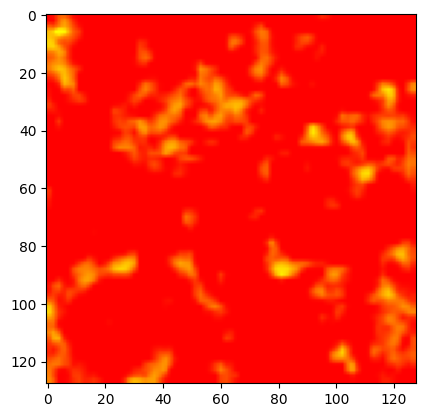

0


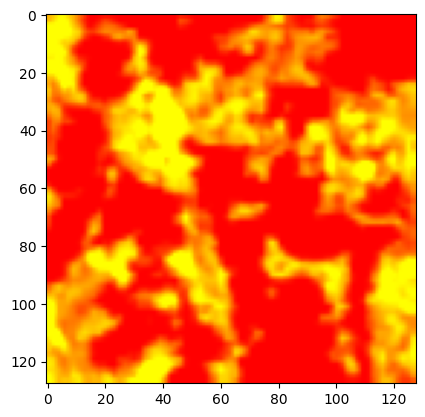

0


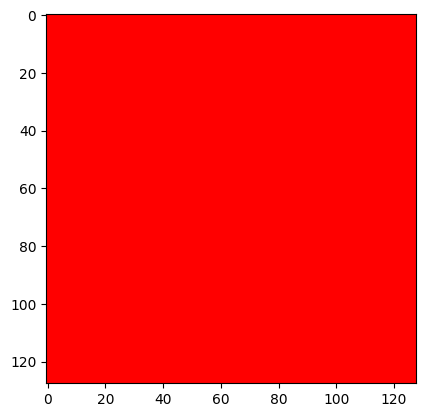

0


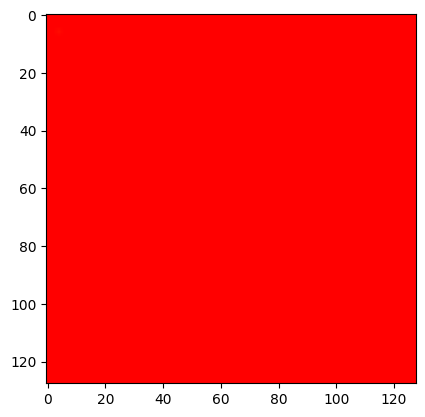

0


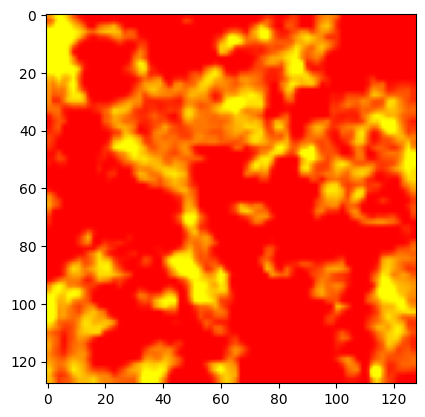

0


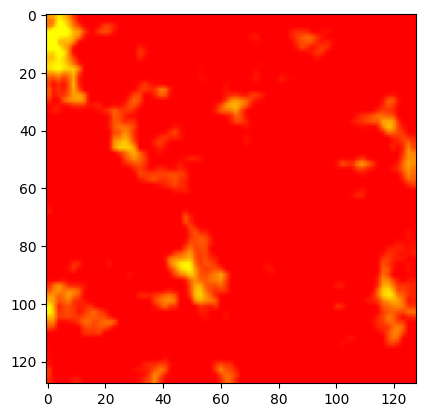

0


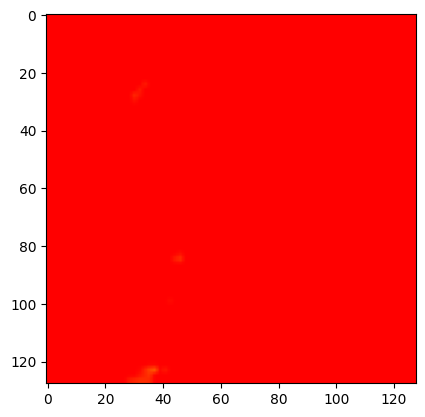

0


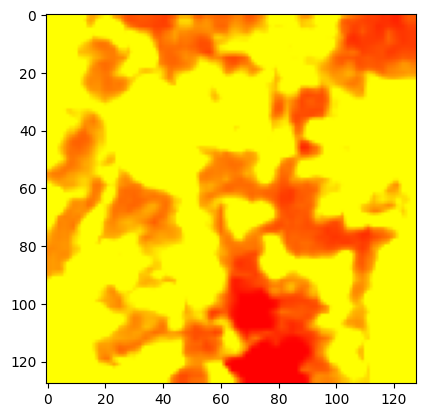

0


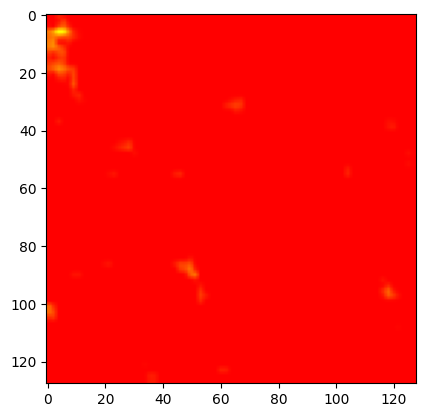

0


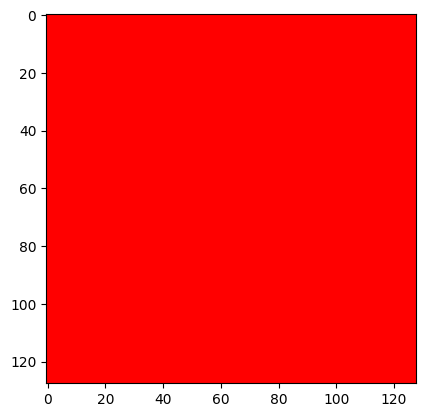

0


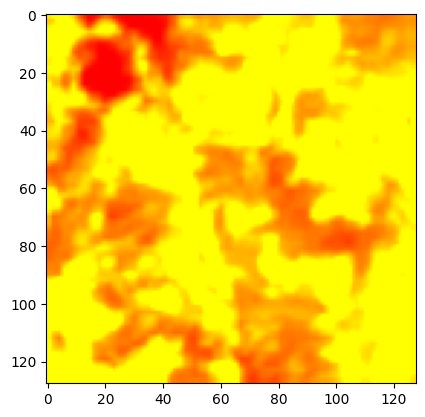

0


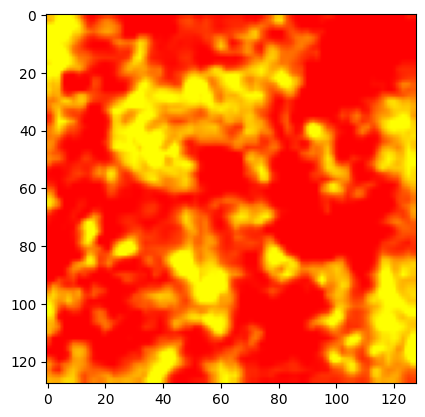

0


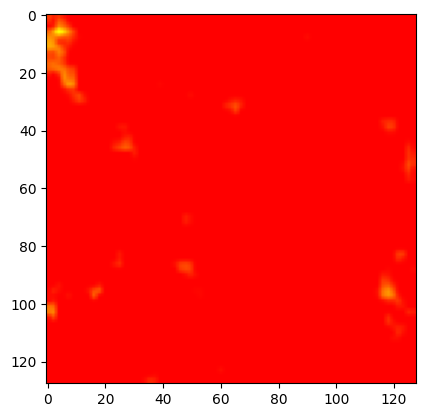

0


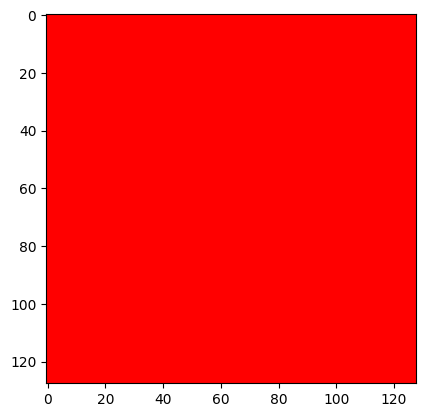

0


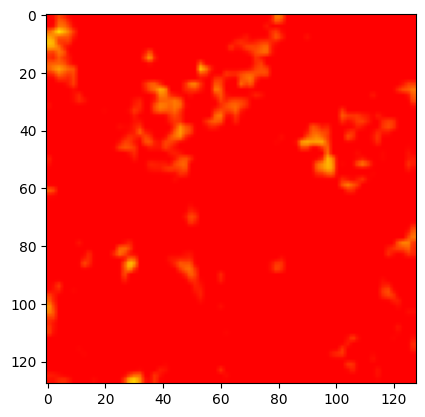

0


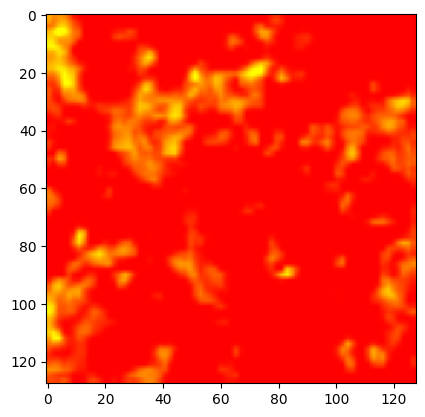

In [90]:
n = data[dir_paths[0]]
print(n.shape)
for i in n:
  print(np.sum(np.isnan(i)))
  plt.imshow(np.clip(i*(6/255),0,1))
  plt.show()

# Cut images

In [3]:
def crop_rasters_with_metadata(input_paths, output_paths):
    """
    Crops each raster file to the central 64x64 pixel area and updates metadata to reflect new bounds.
    
    Parameters:
    input_paths (list of str): List of file paths to the input rasters.
    output_paths (list of str): List of file paths for saving cropped rasters.
    """
    for input_path, output_path in zip(input_paths, output_paths):
        print('Come from', input_path)
        print('I go to', output_path)
        with rasterio.open(input_path) as src:
            # Define the crop window for central 64x64 pixels
            left = (src.width - 64) // 2
            top = (src.height - 64) // 2
            window = Window(left, top, 64, 64)
            
            # Read the cropped window data
            cropped_data = src.read(window=window)
            
            # Update profile and adjust the transform to reflect the new bounds
            profile = src.profile
            profile.update({
                'width': 64,
                'height': 64,
                'transform': rasterio.windows.transform(window, src.transform)
            })
            
            # Write the cropped raster with updated metadata
            with rasterio.open(output_path, 'w', **profile) as dst:
                dst.write(cropped_data)

In [33]:
def load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path='../data/preprocessed/',
    data_paths=['lst', 'slope', 'discharge', 'ndvi', 'altitude'],
    filter_altitude=None,
    W=256,
    time_split=False,
):
    
    dir_paths = [os.path.join(source_path, p) for p in data_paths]
    
    all_dir_paths = {k: [] for k in data_paths}
    total_data = {}
    total_times = {}

    if not filter_altitude:
        rivers = [f.split('station_')[-1].split('.')[0] for f in os.listdir(source_folder) if os.path.join(source_folder, f).endswith('shp')]
    else:
        rivers = get_rivers_altitude(source_folder)
    
    # Cargar rutas de entrada
    for i, dir_p in enumerate(dir_paths):
        for subdir, dirs, files in os.walk(dir_p):
            if subdir != dir_p and not subdir.endswith('masked') and not subdir.endswith('.ipynb_checkpoints') and subdir.split('/')[-1] in rivers:
                all_dir_paths[data_paths[i]].append(subdir)
            elif dir_p.endswith('altitude'):
                all_dir_paths[data_paths[i]].extend([f for f in files if f.split('.')[0] in rivers])
      
    # Cargar datos de entrada
    
    for k, v in all_dir_paths.items():
        if k not in ['discharge', 'slope', 'altitude']:
            labels = []
            list_rgb = [True] * len(v) if k in ['lst', 'masked'] else [False] * len(v)
            data, times = load_data(v, W, list_rgb)
            if k != 'masked':
                for ki in data.keys():
                    labels += [ki.split('/')[-1]] * len(data[ki])

            data_values = [np.array(img) for sublist in list(data.values()) for img in sublist]
            times_list = [t for sublist in times for t in sublist]

            if time_split:
                dates = [datetime.strptime(date, '%Y-%m') for date in times_list]
                pairs = sorted(zip(dates, data_values, labels), key=lambda x: x[0])
                sorted_dates, data_values, labels = zip(*pairs)
                times_list = [date.strftime('%Y-%m') for date in sorted_dates]

            total_data[k] = np.array(data_values)
            total_times[k] = times_list
            print(f"{k} : {total_data[k].shape}")

    # Cargar variables adicionales
    for k, v in all_dir_paths.items():
        if k in ['discharge', 'slope', 'altitude']:
            imgss = {}
            total = []
            for i, lab in enumerate(labels):
                for file in v:
                    if lab in file.split('/')[-1] or lab in file.split('.')[0]:
                        if lab not in imgss:
                            file_path = os.path.join(file, os.listdir(file)[0]) if k != 'altitude' else os.path.join('../data/preprocessed/altitude', file)
                            r, m = load_raster(file_path, False)
                            var = resize_image(r, W, W)
                            var = np.where(np.isnan(var), 0.0, var)
                            imgss[lab] = var
                        else:
                            var = imgss[lab]
                            
                total.append(var)

            total_data[k] = np.array(total)
            print(f"{k}: {np.array(total).shape}")

    # Cargar variable objetivo
    water_temp = pd.read_csv('../data/preprocessed/wt/water_temp.csv', index_col=0)
    times_ordered = total_times['lst']
    wt_temp = []
    for cell, date in zip(labels, times_ordered):
        temp = water_temp[(water_temp["Cell"] == cell) & (water_temp["Date"] == date)]["WaterTemp"]
        if not temp.empty:
            wt_temp.append(temp.values[0])
    data_targets = np.array(wt_temp)

    return total_data, total_times, data_targets, labels

In [34]:
inputs = ['lst','ndvi','discharge', 'slope', 'altitude']
split = 'random'
W = 128

data = load_all_data(
    source_folder='../data/external/shp/river_cells_oficial',
    source_path='../data/preprocessed/',
    data_paths= inputs,
    filter_altitude=False,
    W=W,
    time_split=True if split=='time' else False)

total_data, total_times, data_targets, labels = data

lst : (1628, 128, 128, 3)
ndvi : (1628, 128, 128)
discharge: (1628, 128, 128)
slope: (1628, 128, 128)
altitude: (1628, 128, 128)


In [97]:
len(np.unique(labels))

80

In [112]:
from rasterio.windows import Window
last=0
clear_directory('../data/preprocessed/64x64')
os.makedirs('../data/preprocessed/64x64/lst',exist_ok=True)
for cell in os.listdir('../data/preprocessed/lst'):
    cell_folder = os.path.join('../data/preprocessed/lst',cell)
    imgs = [f'{cell_folder}/{file}' for file in os.listdir(cell_folder)]
    dates = [re.search(r"\d{4}-\d{2}", path).group(0) for path in imgs]
    
    os.makedirs(f'../data/preprocessed/64x64/lst/{cell}',exist_ok=True)
    dest_imgs = [f'../data/preprocessed/64x64/lst/{cell}/image_{time}.tiff' for time in dates]
    crop_rasters_with_metadata(imgs, dest_imgs)
    print('done',cell)



Come from ../data/preprocessed/lst/cell_67/image_2022-03.tiff
I go to ../data/preprocessed/64x64/lst/cell_67/image_2022-03.tiff
Come from ../data/preprocessed/lst/cell_67/image_2020-03.tiff
I go to ../data/preprocessed/64x64/lst/cell_67/image_2020-03.tiff
Come from ../data/preprocessed/lst/cell_67/image_2022-12.tiff
I go to ../data/preprocessed/64x64/lst/cell_67/image_2022-12.tiff
Come from ../data/preprocessed/lst/cell_67/image_2014-02.tiff
I go to ../data/preprocessed/64x64/lst/cell_67/image_2014-02.tiff
Come from ../data/preprocessed/lst/cell_67/image_2013-08.tiff
I go to ../data/preprocessed/64x64/lst/cell_67/image_2013-08.tiff
Come from ../data/preprocessed/lst/cell_67/image_2020-06.tiff
I go to ../data/preprocessed/64x64/lst/cell_67/image_2020-06.tiff
Come from ../data/preprocessed/lst/cell_67/image_2021-09.tiff
I go to ../data/preprocessed/64x64/lst/cell_67/image_2021-09.tiff
Come from ../data/preprocessed/lst/cell_67/image_2023-02.tiff
I go to ../data/preprocessed/64x64/lst/cel

In [103]:
last=0
os.makedirs('../data/preprocessed/64x64/ndvi',exist_ok=True)
for cell in os.listdir('../data/preprocessed/ndvi'):
    cell_folder = os.path.join('../data/preprocessed/ndvi',cell)
    imgs = [f'{cell_folder}/{file}' for file in os.listdir(cell_folder)]
    dates = [re.search(r"\d{4}-\d{2}", path).group(0) for path in imgs]
    os.makedirs(f'../data/preprocessed/64x64/ndvi/{cell}',exist_ok=True)
    dest_imgs = [f'../data/preprocessed/64x64/ndvi/{cell}/ndvi_{time}.tiff' for time in dates]
    crop_rasters_with_metadata(imgs, dest_imgs)
    last+=1
    print('Done',cell,last)

Come from ../data/preprocessed/ndvi/cell_67/ndvi_2023-02.tiff
I go to ../data/preprocessed/64x64/ndvi/cell_67/ndvi_2023-02.tiff
Come from ../data/preprocessed/ndvi/cell_67/ndvi_2014-02.tiff
I go to ../data/preprocessed/64x64/ndvi/cell_67/ndvi_2014-02.tiff
Come from ../data/preprocessed/ndvi/cell_67/ndvi_2022-03.tiff
I go to ../data/preprocessed/64x64/ndvi/cell_67/ndvi_2022-03.tiff
Come from ../data/preprocessed/ndvi/cell_67/ndvi_2022-12.tiff
I go to ../data/preprocessed/64x64/ndvi/cell_67/ndvi_2022-12.tiff
Come from ../data/preprocessed/ndvi/cell_67/ndvi_2023-12.tiff
I go to ../data/preprocessed/64x64/ndvi/cell_67/ndvi_2023-12.tiff
Come from ../data/preprocessed/ndvi/cell_67/ndvi_2022-08.tiff
I go to ../data/preprocessed/64x64/ndvi/cell_67/ndvi_2022-08.tiff
Come from ../data/preprocessed/ndvi/cell_67/ndvi_2020-06.tiff
I go to ../data/preprocessed/64x64/ndvi/cell_67/ndvi_2020-06.tiff
Come from ../data/preprocessed/ndvi/cell_67/ndvi_2023-10.tiff
I go to ../data/preprocessed/64x64/ndvi/ce

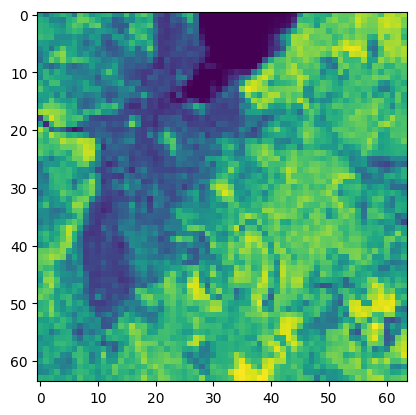

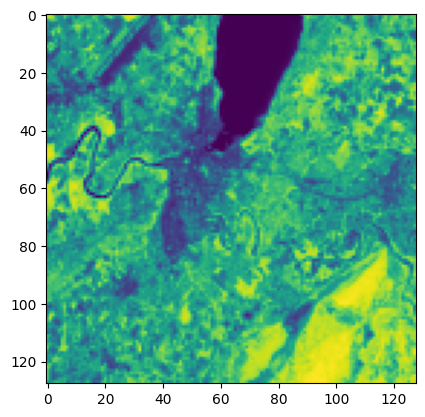

(64, 64, 3) (128, 128, 3)


In [105]:
cut,mm=  load_raster('../data/preprocessed/64x64/ndvi/cell_67/ndvi_2020-03.tiff',False)
original,m = load_raster('../data/preprocessed/ndvi/cell_67/ndvi_2020-03.tiff',False)
plt.imshow(np.clip(cut*(6/255),0,1))
plt.show()
plt.imshow(np.clip(original*(6/255),0,1))
plt.show()
print(crop[0].shape,total_data['lst'][0].shape)

# Pixel wise dataset creation

<Axes: >

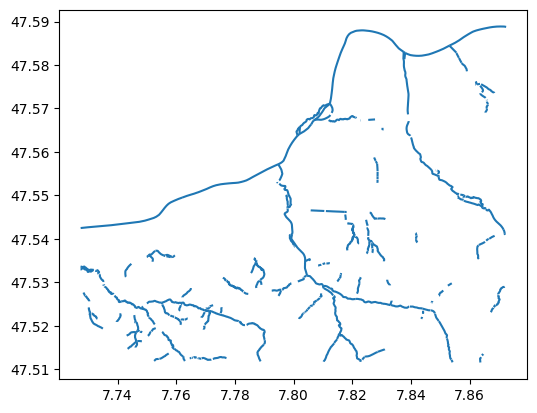

In [60]:
river_cells['cell_73'].plot()

cell_31


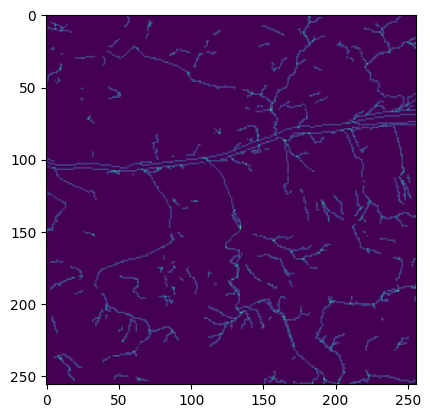

cell_71


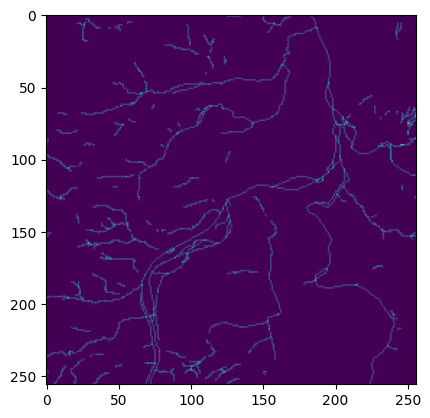

cell_1


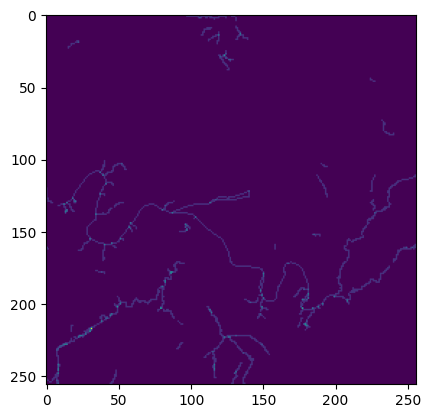

cell_45


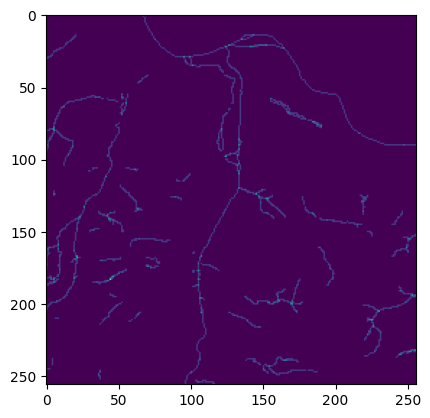

cell_35


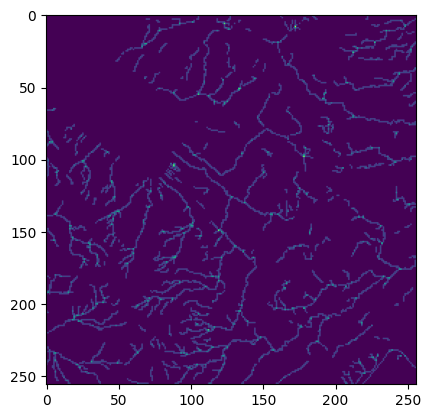

cell_25


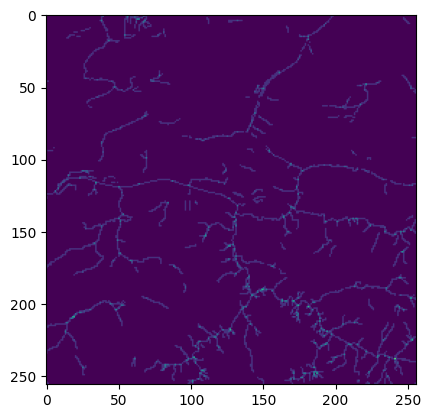

cell_21


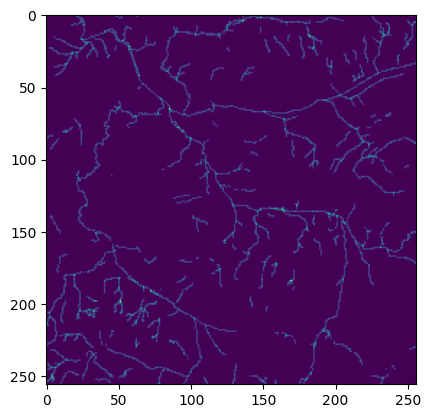

cell_51


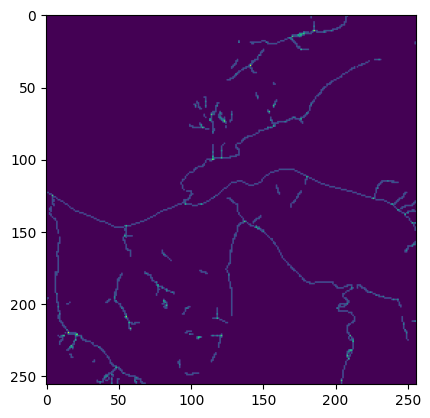

cell_49


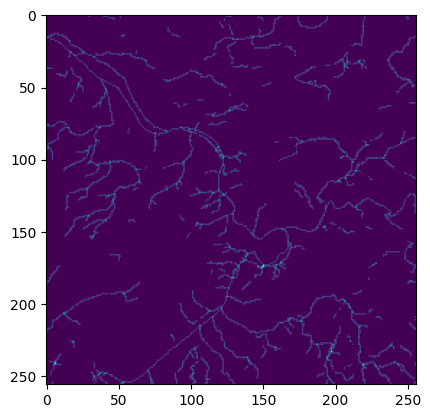

cell_12


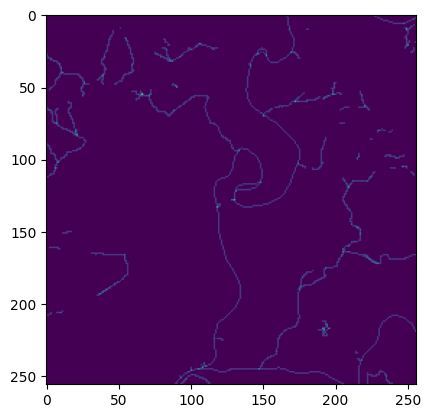

cell_58


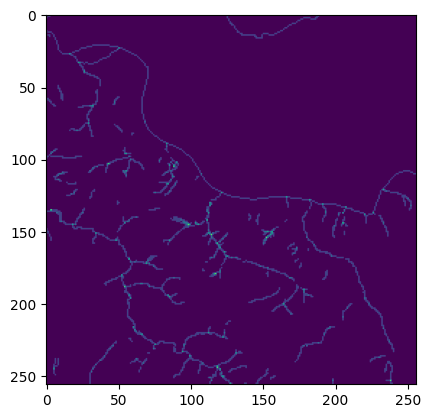

cell_46


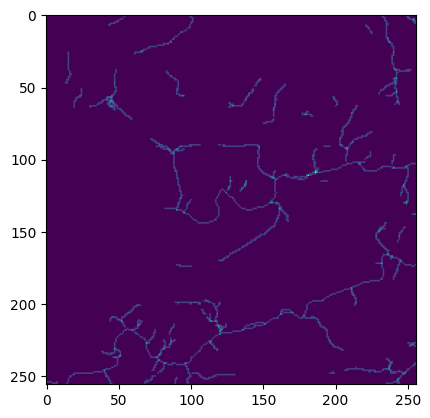

cell_53


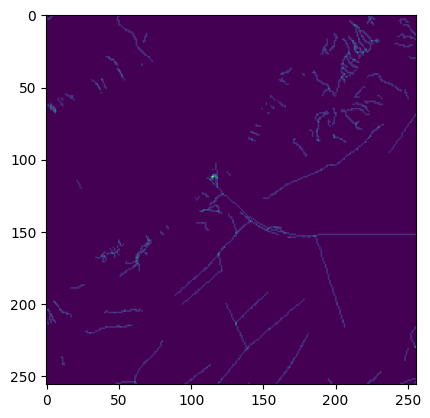

cell_55


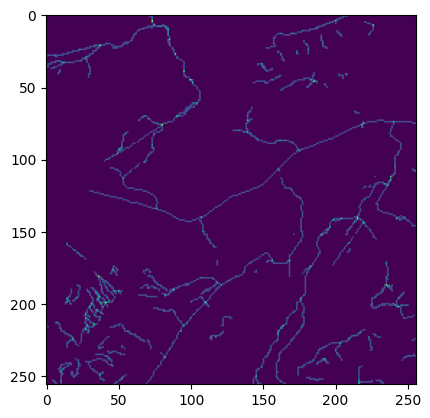

cell_5


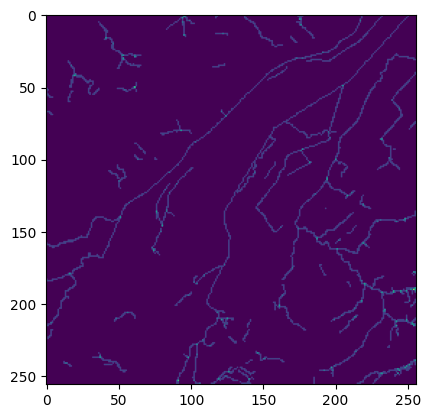

cell_62


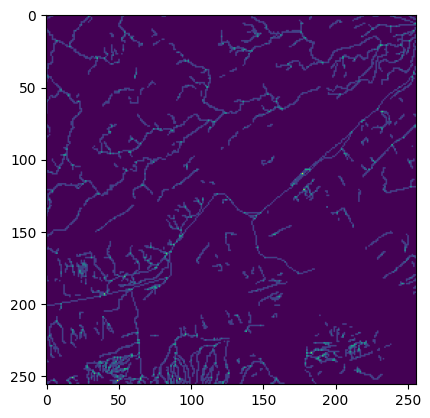

cell_67


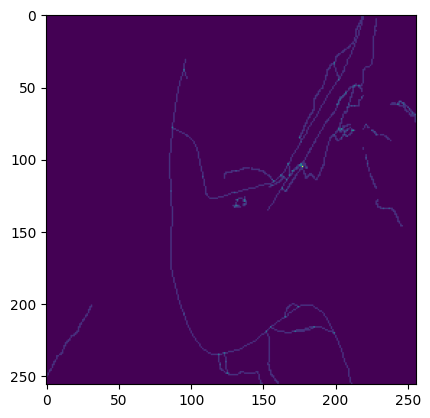

cell_14


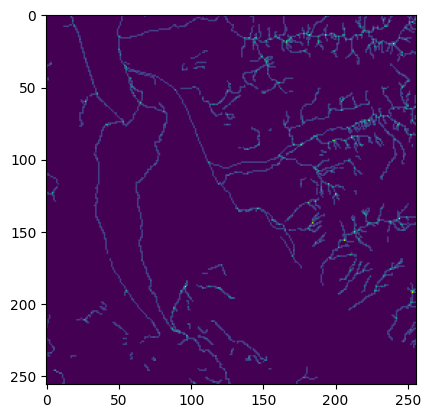

cell_24


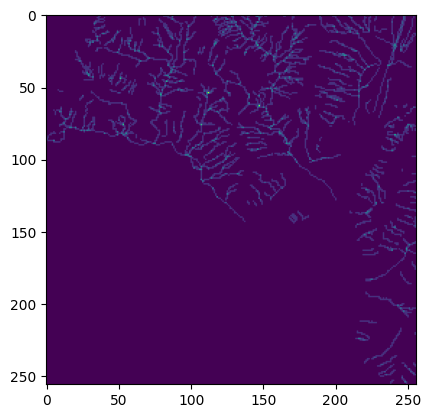

cell_26


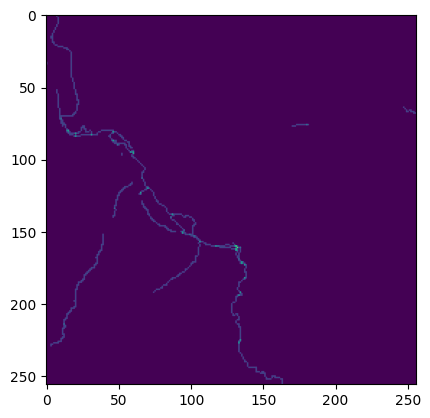

cell_81


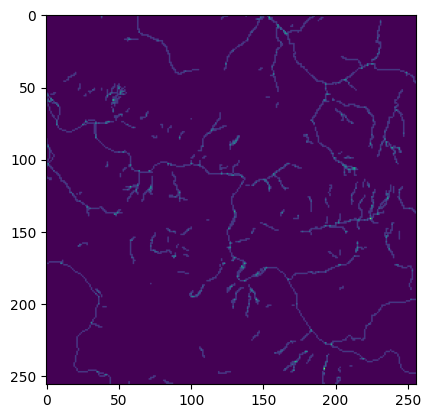

cell_54


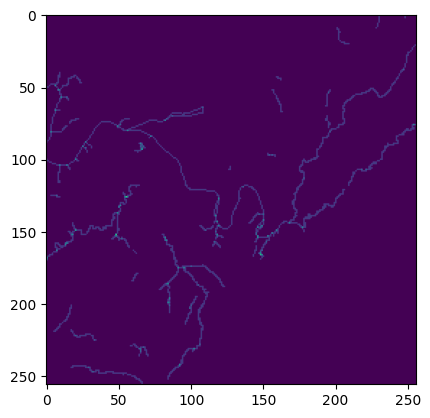

cell_9


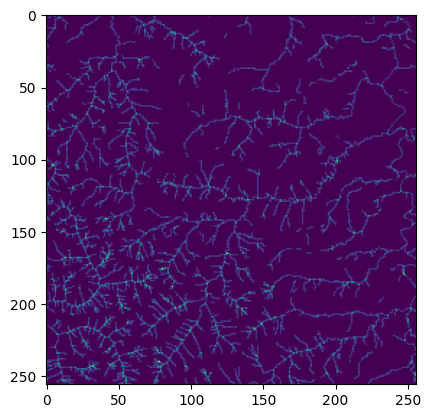

cell_73


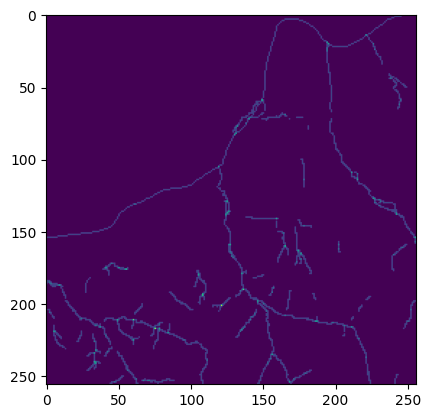

cell_69


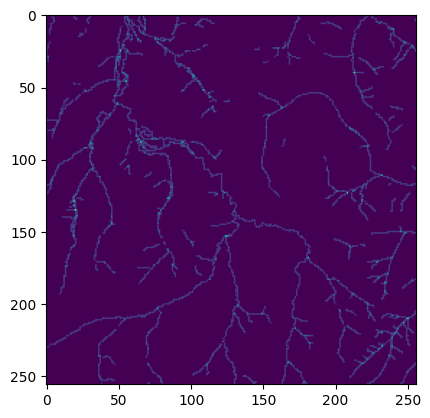

cell_47


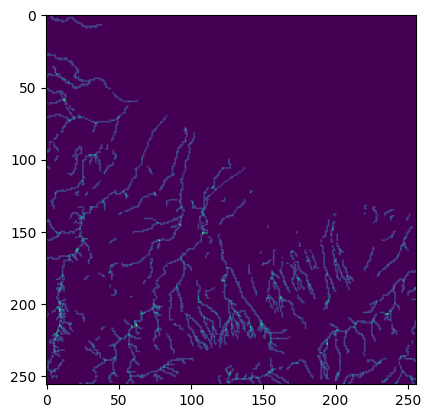

cell_15


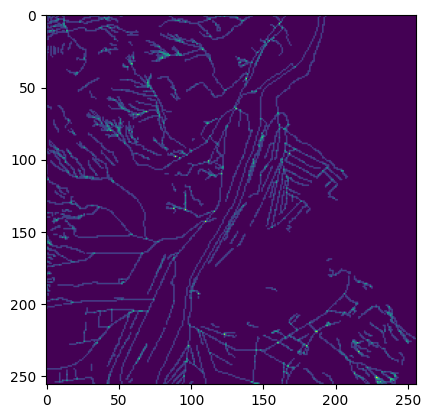

cell_11


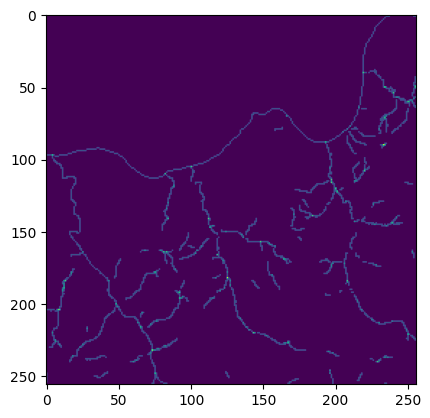

cell_20


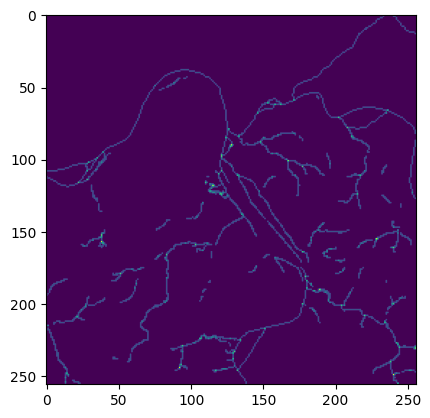

cell_70


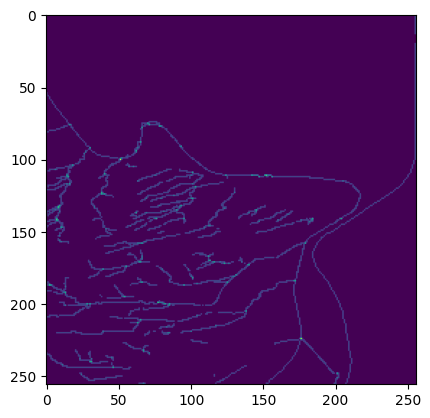

cell_22


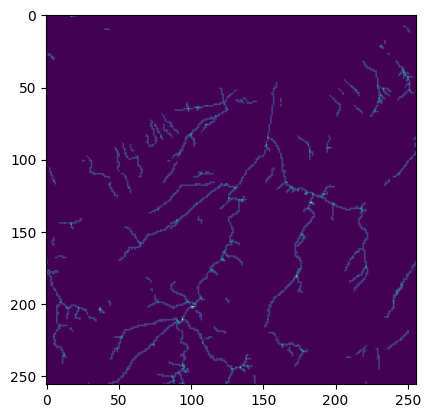

cell_65


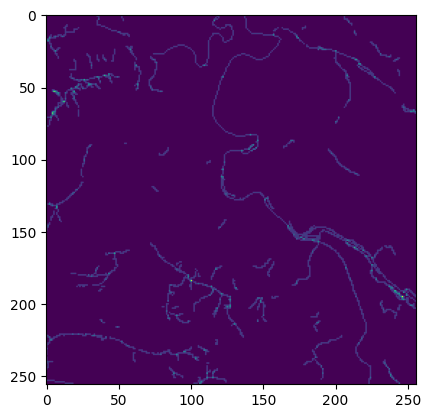

cell_4


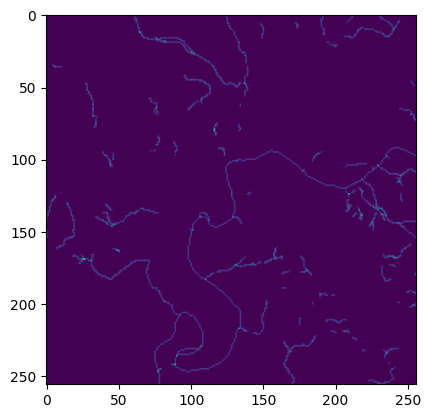

cell_13


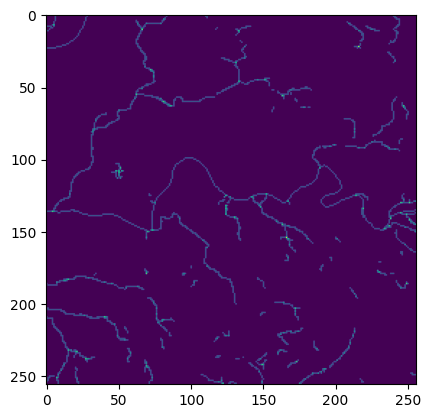

cell_41


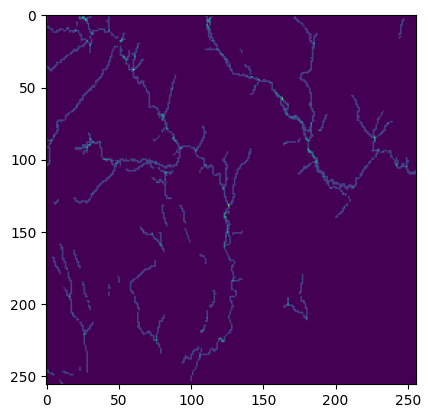

cell_63


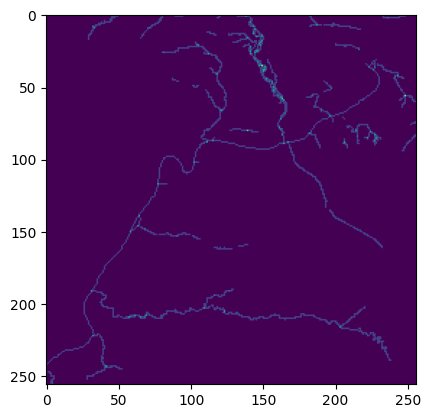

cell_79


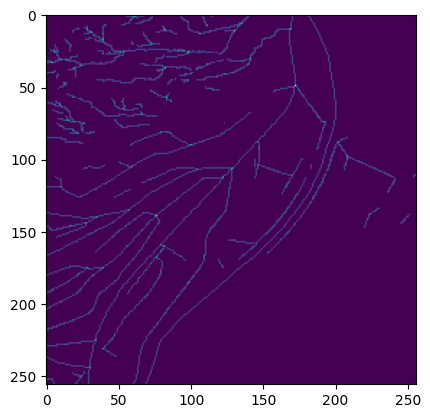

cell_19


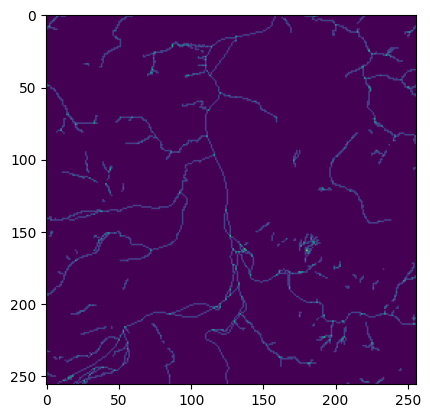

cell_75


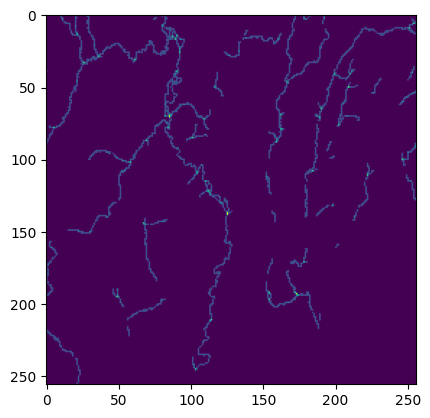

cell_48


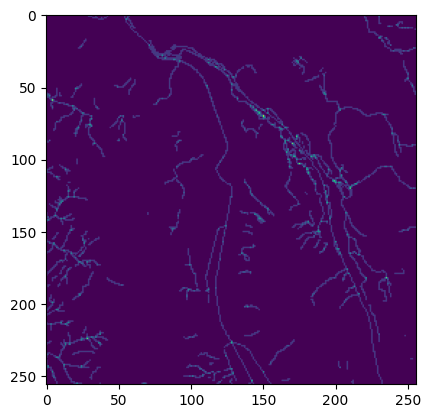

cell_27


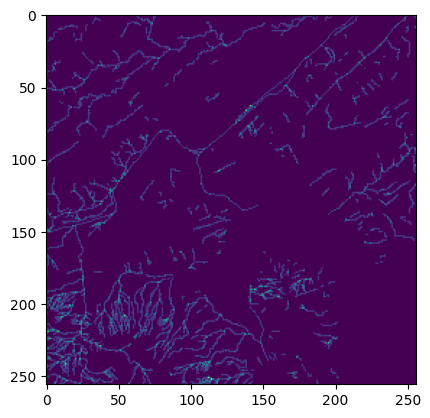

cell_56


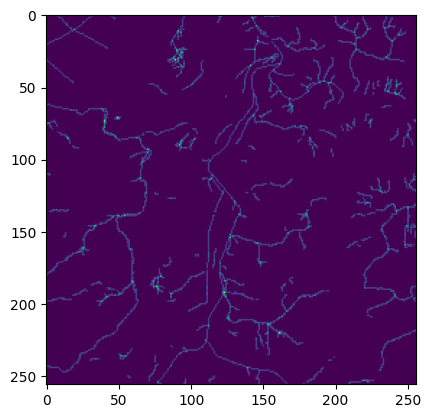

cell_36


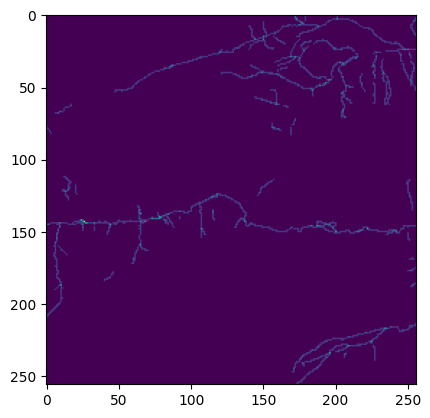

cell_7


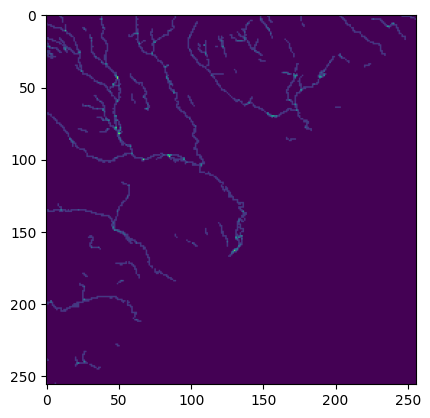

cell_52


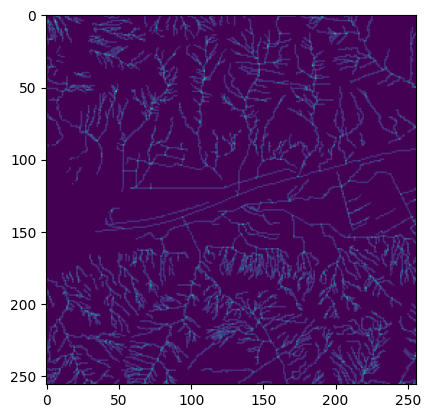

cell_61


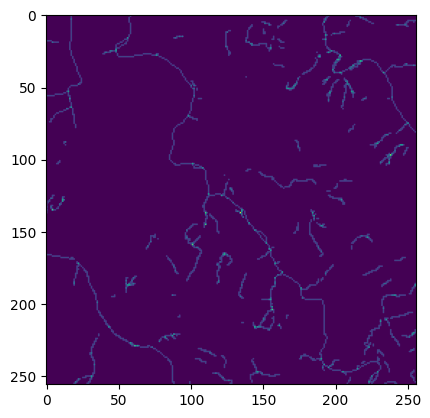

cell_72


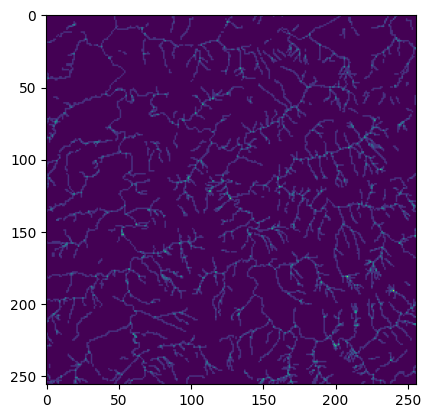

cell_38


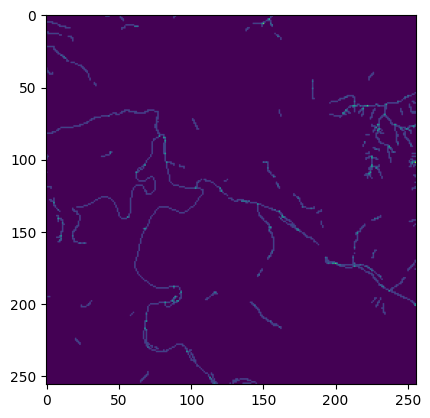

In [68]:
dir_path = '../data/external/raster_masks/'
files = os.listdir(dir_path)
river_masks = {}
river_masks_expanded = {}
for raster in files:
    cl_int=raster.split('bw_cell_')[-1].split('.')[0]
    cc = raster.split('bw_')[-1].split('.')[0]
    raster_path = os.path.join(dir_path, raster)
    rast,meta = load_raster(raster_path,False)
    river_masks[cc]=rast
    if cc in total_cells:
        print(cc)
        plt.imshow(rast)
        plt.show()
    river_mask_expanded = np.expand_dims(rast, axis=-1)  # Expande para tener forma (height, width, 1)
    river_mask_expanded = np.repeat(river_mask_expanded, lst.shape[-1], axis=-1)  # Expande a (height, width, 3)
    river_masks_expanded[cc] = river_mask_expanded
    

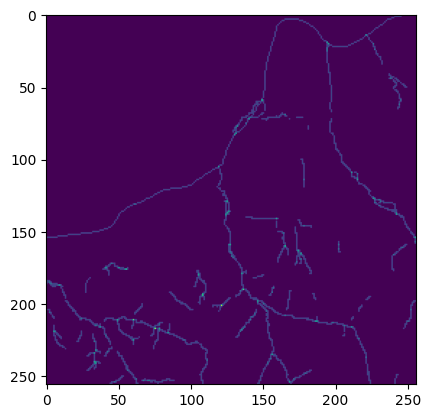

In [139]:
plt.imshow(river_masks['cell_73'])

### LST dataset

In [69]:
c=0
last = 0
source_path = '../data/preprocessed/'
for i, (cell, im_per_river) in enumerate(imgs_per_river.items()):
    try:
        river_mask = river_masks[cell]
        river_indices = np.nonzero(river_mask.reshape(-1))[0]
        pixel_ds_lst = pd.DataFrame(columns=[river_indices])
    
        for count in range(im_per_river):
            ind = count + last
            image = lst[ind]
            img_gray = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
            flat_image = img_gray.flatten()
            river_image = flat_image[river_indices]
            pixel_ds_lst.loc[t[0][c][count-1]] = river_image
        
        last += im_per_river
        print((pixel_ds_lst.shape))
        csv_path = f'{source_path}lst/{cell}/{cell}.csv'
        if os.path.exists(csv_path):
            os.remove(csv_path)
        pixel_ds_lst.to_csv(csv_path)# index=False)
        print('Guardat',csv_path)
        c+=1
    except KeyError:
        pass


(29, 1568)
Guardat ../data/preprocessed/lst/cell_67/cell_67.csv
(11, 4428)
Guardat ../data/preprocessed/lst/cell_31/cell_31.csv
(13, 3348)
Guardat ../data/preprocessed/lst/cell_19/cell_19.csv
(7, 3592)
Guardat ../data/preprocessed/lst/cell_71/cell_71.csv
(20, 4725)
Guardat ../data/preprocessed/lst/cell_49/cell_49.csv
(17, 2430)
Guardat ../data/preprocessed/lst/cell_13/cell_13.csv
(37, 2719)
Guardat ../data/preprocessed/lst/cell_41/cell_41.csv
(14, 4728)
Guardat ../data/preprocessed/lst/cell_21/cell_21.csv
(6, 2391)
Guardat ../data/preprocessed/lst/cell_11/cell_11.csv
(16, 2606)
Guardat ../data/preprocessed/lst/cell_58/cell_58.csv
(41, 4131)
Guardat ../data/preprocessed/lst/cell_56/cell_56.csv
(19, 6395)
Guardat ../data/preprocessed/lst/cell_62/cell_62.csv
(14, 9302)
Guardat ../data/preprocessed/lst/cell_72/cell_72.csv
(25, 2982)
Guardat ../data/preprocessed/lst/cell_65/cell_65.csv
(16, 9822)
Guardat ../data/preprocessed/lst/cell_9/cell_9.csv
(9, 4501)
Guardat ../data/preprocessed/lst/c

### NDVI dataset

In [70]:
c=0
last = 0
for i, (cell, im_per_river) in enumerate(imgs_per_river.items()):
    try:
        river_mask = river_masks[cell]
        river_indices = np.nonzero(river_mask.reshape(-1))[0]
        pixel_ds_ndvi = pd.DataFrame(columns=[river_indices])
    
        for count in range(im_per_river):
            ind = count + last
            image = fixed_ndvi[ind]
            flat_image = image.flatten()
            river_image = flat_image[river_indices]
            pixel_ds_ndvi.loc[t[0][c][count-1]] = river_image
        
        last += im_per_river
        print(pixel_ds_ndvi.shape)
        csv_path = f'{source_path}ndvi/{cell}/{cell}.csv'
        if os.path.exists(csv_path):
            os.remove(csv_path)
        pixel_ds_ndvi.to_csv(csv_path)#index=False)
        print('Guardat',csv_path)
        c+=1
    except KeyError:
        pass


(29, 1568)
Guardat ../data/preprocessed/ndvi/cell_67/cell_67.csv
(11, 4428)
Guardat ../data/preprocessed/ndvi/cell_31/cell_31.csv
(13, 3348)
Guardat ../data/preprocessed/ndvi/cell_19/cell_19.csv
(7, 3592)
Guardat ../data/preprocessed/ndvi/cell_71/cell_71.csv
(20, 4725)
Guardat ../data/preprocessed/ndvi/cell_49/cell_49.csv
(17, 2430)
Guardat ../data/preprocessed/ndvi/cell_13/cell_13.csv
(37, 2719)
Guardat ../data/preprocessed/ndvi/cell_41/cell_41.csv
(14, 4728)
Guardat ../data/preprocessed/ndvi/cell_21/cell_21.csv
(6, 2391)
Guardat ../data/preprocessed/ndvi/cell_11/cell_11.csv
(16, 2606)
Guardat ../data/preprocessed/ndvi/cell_58/cell_58.csv
(41, 4131)
Guardat ../data/preprocessed/ndvi/cell_56/cell_56.csv
(19, 6395)
Guardat ../data/preprocessed/ndvi/cell_62/cell_62.csv
(14, 9302)
Guardat ../data/preprocessed/ndvi/cell_72/cell_72.csv
(25, 2982)
Guardat ../data/preprocessed/ndvi/cell_65/cell_65.csv
(16, 9822)
Guardat ../data/preprocessed/ndvi/cell_9/cell_9.csv
(9, 4501)
Guardat ../data/pre

### Water temperature dataset

In [30]:
c=0
last = 0
for i, (cell, im_per_river) in enumerate(imgs_per_river.items()):
    try:
        river_mask = river_masks[cell]
        river_indices = np.nonzero(river_mask.reshape(-1))[0]
        pixel_ds_wt = pd.DataFrame(columns=[river_indices])
    
        for count in range(im_per_river):
            ind = count + last
            image = data_targets[ind]
            flat_image = image.flatten()
            river_image = flat_image[river_indices]
            pixel_ds_wt.loc[total_times['lst'][c][count-1]] = river_image
        
        last += im_per_river
        print(pixel_ds_wt.shape)
        csv_path = f'{source_path}wt/{cell}/{cell}.csv'
        if os.path.exists(csv_path):
            os.remove(csv_path)
        pixel_ds_wt.to_csv(csv_path)#, index=False)
        print('Guardat',csv_path)
        c+=1
    except KeyError:
        pass


(8, 10266)
Guardat ../data/preprocessed/wt/cell_163/cell_163.csv
(5, 3691)
Guardat ../data/preprocessed/wt/cell_146/cell_146.csv
(3, 4548)
Guardat ../data/preprocessed/wt/cell_72/cell_72.csv
(3, 3859)
Guardat ../data/preprocessed/wt/cell_180/cell_180.csv
(7, 4227)
Guardat ../data/preprocessed/wt/cell_212/cell_212.csv
(15, 11947)
Guardat ../data/preprocessed/wt/cell_23/cell_23.csv
(20, 12913)
Guardat ../data/preprocessed/wt/cell_176/cell_176.csv
(12, 3340)
Guardat ../data/preprocessed/wt/cell_296/cell_296.csv
(7, 8374)
Guardat ../data/preprocessed/wt/cell_197/cell_197.csv
(9, 7804)
Guardat ../data/preprocessed/wt/cell_93/cell_93.csv
(17, 4024)
Guardat ../data/preprocessed/wt/cell_279/cell_279.csv
(17, 10999)
Guardat ../data/preprocessed/wt/cell_354/cell_354.csv
(24, 4658)
Guardat ../data/preprocessed/wt/cell_27/cell_27.csv


### Water temperature stations dataset

In [ ]:
pixel_ds_wt = pd.DataFrame(columns=[river_indices])
pixel_ds_wt

In [ ]:
c = 0
for i in range(len(wt_stations)):
  if times[3][i] in slots:
    image = wt_stations[i]
    flat_image = image.flatten()
    river_image = flat_image[river_indices]
    pixel_ds_wt.loc[slots[c]] = river_image
    c += 1

In [103]:
pixel_ds_lst

0     1     2          18         19         21         22     \
2019-08  20.521967   0.0   0.0  20.521967  20.521967  20.521967  20.521967   
2013-07  20.237665   0.0   0.0  20.237665  20.237665  20.237665  20.237665   
2013-08   2.100885   0.0   0.0   2.100885   2.100885   2.100885   2.100885   
2013-12   3.944910   0.0   0.0   3.944910   3.944910   3.944910   3.944910   
2014-01   8.486841   0.0   0.0   8.486841   8.486841   8.486841   8.486841   
2014-03  14.074945   0.0   0.0  14.074945  14.074945  14.074945  14.074945   
2014-05  19.286921   0.0   0.0  19.286921  19.286921  19.286921  19.286921   
2014-06   7.832971   0.0   0.0   7.832971   7.832971   7.832971   7.832971   
2014-11  14.357203   0.0   0.0  14.357203  14.357203  14.357203  14.357203   
2015-05  20.728327   0.0   0.0  20.728327  20.728327  20.728327  20.728327   
2015-08   4.520624   0.0   0.0   4.520624   4.520624   4.520624   4.520624   
2016-02   5.997400   0.0   0.0   5.997400   5.997400   5.997400   5.997400   
2016-03  20.406397   0.0   0.0  20.406397  20.406397  20.406397  20.406397   
2016-07  18.477381   0.0   0.0  18.477381  18.477381  18.477381  18.477381   
2016-09  11.532801   0.0   0.0  11.532801  11.532801  11.532801  11.532801   
2017-04  15.367579   0.0   0.0  15.367579  15.367579  15.367579  15.367579   
2017-05  20.731195   0.0   0.0  20.731195  20.731195  20.731195  20.731195   
2017-06  14.895472   0.0   0.0  14.895472  14.895472  14.895472  14.895472   
2017-09  19.259607   0.0   0.0  19.259607  19.259607  19.259607  19.259607   
2018-06  21.940516   0.0   0.0  21.940516  21.940516  21.940516  21.940516   
2018-08  18.461878   0.0   0.0  18.461878  18.461878  18.461878  18.461878   
2018-09   3.618310   0.0   0.0   3.618310   3.618310   3.618310   3.618310   
2018-12   8.083490   0.0   0.0   8.083490   8.083490   8.083490   8.083490   
2019-03  20.662348   0.0   0.0  20.662348  20.662348  20.662348  20.662348   

             23    30    33     ... 65415 65416 65424 65425 65441 65442 65443  \
2019-08  20.521967   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-07  20.237665   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-08   2.100885   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2013-12   3.944910   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-01   8.486841   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-03  14.074945   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-05  19.286921   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-06   7.832971   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2014-11  14.357203   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2015-05  20.728327   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2015-08   4.520624   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-02   5.997400   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-03  20.406397   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-07  18.477381   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2016-09  11.532801   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-04  15.367579   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-05  20.731195   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-06  14.895472   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2017-09  19.259607   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-06  21.940516   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-08  18.461878   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-09   3.618310   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2018-12   8.083490   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2019-03  20.662348   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

        65453      65482      65483 

In [ ]:
pixel_ds_wt.to_csv('../data/preprocessed/wt_interpolated/leboiron_wt_interpolated.csv')